# Flowsheet optimization: CO$_2$ tax rate sensitivity
## ROK model: M5; Region: Bakken; CO$_2$ tax rates: USD 0 - 410/tonne CO$_2$e

In [1]:
# simulation case specifications
model_code = 5
case_name = 'Bakken'
c_tax_rate = 0.0

In [2]:
from idaes.core.util.model_statistics import degrees_of_freedom, large_residuals_set

# Import idaes model serializer to store initialized model
from idaes.core.util import model_serializer as ms

from pyomo.environ import (Constraint,
                           ConstraintList,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Set,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value,
                           minimize)

from src.unit_initialization import create_flowsheet, \
                                    define_models, \
                                    define_arcs, \
                                    set_unit_model_variables, \
                                    initialize_flowsheet, \
                                    set_scaling_factors,\
                                    update_model_after_initialization,\
                                    vapor_only_to_vapor_liquid_reformulate,\
                                    update_model_for_optimization, \
                                    unfix_DOFs_pre_optimization, \
                                    fix_DOFs_post_optimization

## Create flowsheet

In [3]:
m = create_flowsheet(model_code)

In [4]:
M_catalyst = 1167.003367 # kg

## Define equipment and connections

In [5]:
# define unit models
define_models(m, catalyst_mass = M_catalyst)
#define connections
define_arcs(m)

## Define inlet compositions

In [6]:
import pandas as pd

inlet_df = pd.read_csv('NGL_compositions.csv')

inlet_composition_dict = {}

for col in inlet_df.columns:
    if col == case_name:
        for i,r in inlet_df.iterrows():
            if r[col] == 0.0:
                inlet_composition_dict[r['Species']] = 1e-6
            else:
                inlet_composition_dict[r['Species']] = round(r[col],4)

inlet_flow_rate = 481.3888889

inlet_composition_dict

dehydro_conv_dict = {'ethane':0.3566,
                     'propane':0.6632,
                     'nbutane':0.5188}

## Define constraints and set-points for equipment

In [7]:
set_unit_model_variables(m, model_code=model_code, feed_flow_rate = inlet_flow_rate, 
                         feed_temp = 308.0, feed_pressure = 700000.0,
                         inlet_composition_dict = inlet_composition_dict,
                         dehydro_conv_dict = dehydro_conv_dict)

## Scale model components

In [8]:
if model_code == 2 or model_code == 3:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-2, inlet_composition_dict = inlet_composition_dict)
elif model_code == 4 or model_code == 5:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-3, inlet_composition_dict = inlet_composition_dict)
else:
    pass

## Read-in initialization data from .json file

In [9]:
init_file_name = "./initialization_files/CISTAR_unit_initialization_{}_M{}.json.gz".format(case_name, model_code)
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.05828714370727539,
 'etime_read_dict': 0.16122865676879883,
 'etime_read_suffixes': 0.004982471466064453}

## Add post-initialization constraints

In [10]:
update_model_after_initialization(m)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)

Liquid phase flow is zero. Translator block fs.T102 liquid phase composition equations are being modified...

Degenerate constraints removed and liquid phase composition values set to 1e-8

Translator block fs.T102 liquid phase composition equations already modified, no degenerate constraints remaining.



## Read-in flowsheet convergence data from .json file

In [11]:
init_file_name = "./initialization_files/CISTAR_solve_constrained_{}_M{}_purge_{}.json.gz".format(case_name, model_code,round(m.fs.S102.split_fraction[0, "purge"](),3))
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.07183146476745605,
 'etime_read_dict': 0.1591329574584961,
 'etime_read_suffixes': 0.0}

## Costing

In [12]:
from src.emissions_calculations import calc_lhv_values, calculate_stream_energies, calculate_emissions, create_ghg_objective
from src.costing_function import add_costing,calculate_costs_for_objective
from src.utility_minimization_1d import (
    min_utility,
    PinchDataClass,
    heat_ex_data,
    gen_curves,
    print_HX_results,
    generate_curves,
    heat_data,
    pinch_calc,
    return_data
)

### Equipment costing

In [13]:
add_costing(m)

### Heat integration

In [14]:
### Heat Exchangers and reactors
min_utility(
    m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102], 10.0
)
m.fs.Qs.fix()

### Emissions calculation

In [15]:
calc_lhv_values(m,case_name,'./LHV.xlsx','NGL_compositions.csv','NGL_fraction.csv')
calculate_stream_energies(m)
calculate_emissions(m,case_name,'emissions_factor_by_region.csv')
create_ghg_objective(m)
calculate_costs_for_objective(m,c_tax_flag=True, c_tax_val = c_tax_rate)
costing_initialized = True

## Read-in initialization file from .json file with CO$_2$ tax rate = 0

In [17]:
init_file_name = "./initialization_files/CISTAR_solve_with_costing_{}_C_tax_{}_M{}_purge_{}.json.gz".format(case_name,m.fs.c_tax_rate(), model_code,round(m.fs.S102.split_fraction[0, "purge"](),3))
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.05757451057434082,
 'etime_read_dict': 0.16399431228637695,
 'etime_read_suffixes': 0.0}

## List of CO$_2$ tax rates evaluated

In [16]:
c_tax_rates = [0.0,1e-5,1e-3,1.7e-2,4.5e-2,1.9e-1,4.1e-1] # USD/kg CO2e; units changed to match process model units (1 tonne = 1000 kg)

## Flowsheet optimization with 8 DOFs

In [18]:
update_model_for_optimization(m)

Model updates:


Constraint added for recycle ratio <= 8.0.

fs.H103 temperature lower and upper bounds added.

fs.R102 isothermal operation constraint added.

fs.H106 temperature lower bound updated.

fs.F102 temperature lower bound updated.

Objective function added.



The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

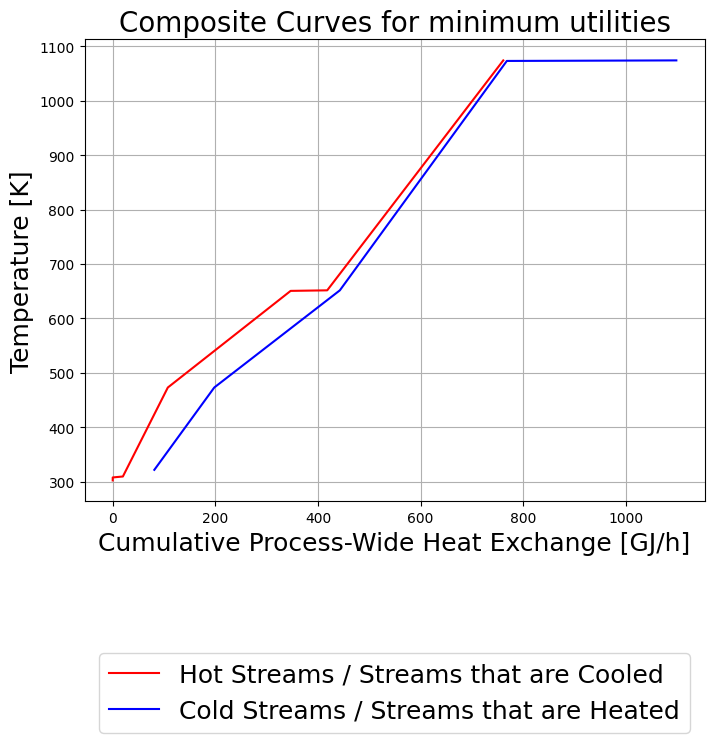

Heat utility =  337.2580495996524 GJ/h
cold utility =  81.10180866548102 GJ/h
Downstream emissions =  8.861411589793526 kg CO2e/GJ fuel
MSP =  10.38914566593144 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1521.1     2002.5
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17774    0.13501
    Total Mole Fraction methane   dimensionless   0.081100    0.27282    0.22673
    Total Mole Fraction ethane    dimensionless    0.46920    0.20919    0.27169
    Total Mole Fraction propane   dimensionless    0.30920   0.046594    0.10972
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032214
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074828   0.06321


Unit : fs.T103                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                           Units        Inlet      Outlet  
    Molar Flowrate ('Liq', 'ethane')    mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'propane')   mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'nbutane')   mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'ibutane')   mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'pentane')   mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'hexane')    mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'heptane')   mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'octane')    mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'ethylene')  mole / second 1.0000e-08          -
    Molar Flowrate ('Liq', 'propene')   mole / secon

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

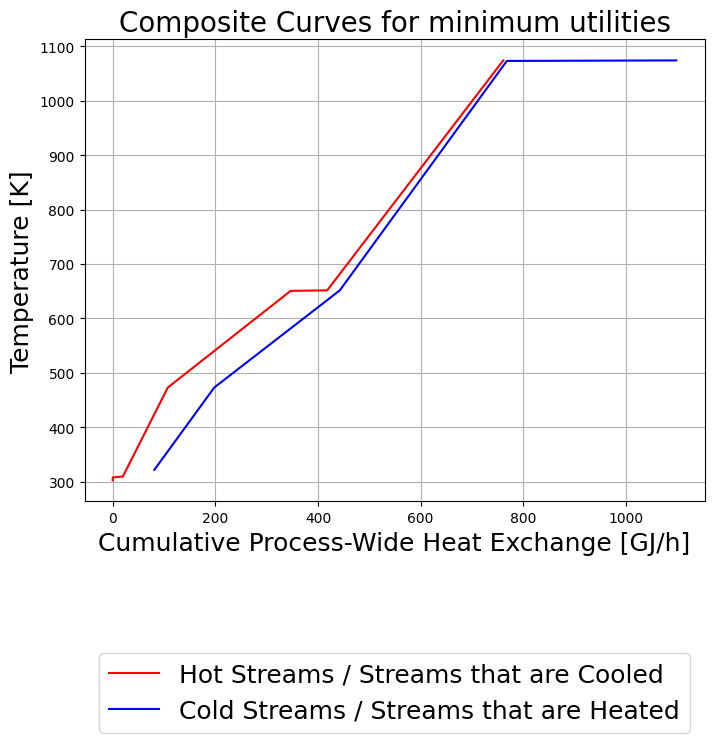

Heat utility =  337.25777531370494 GJ/h
cold utility =  81.10169599588009 GJ/h
Downstream emissions =  8.861401904880319 kg CO2e/GJ fuel
MSP =  10.389360658290428 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1521.1     2002.5
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17774    0.13501
    Total Mole Fraction methane   dimensionless   0.081100    0.27282    0.22673
    Total Mole Fraction ethane    dimensionless    0.46920    0.20919    0.27170
    Total Mole Fraction propane   dimensionless    0.30920   0.046594    0.10972
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032214
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074826   0.063

    Key                   : Value      : Units         : Fixed : Bounds
    Isentropic Efficiency :    0.85000 : dimensionless :  True : (None, None)
          Mechanical Work :     55708. :          watt : False : (None, None)
          Pressure Change : 3.6804e+05 :        pascal : False : (None, None)
           Pressure Ratio :     3.8348 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                     Units         Inlet     Outlet  
    Total Molar Flowrate          mole / second     13.184     13.184
    Total Mole Fraction ethane    dimensionless    0.25648    0.25648
    Total Mole Fraction propane   dimensionless   0.099919   0.099919
    Total Mole Fraction nbutane   dimensionless   0.046989   0.046989
    Total Mole Fraction ibutane   dimensionless    0.19302    0.19302
    Total Mole Fraction pentane   dimensionless   0.042645   0.042645
    Total Mole Fraction

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

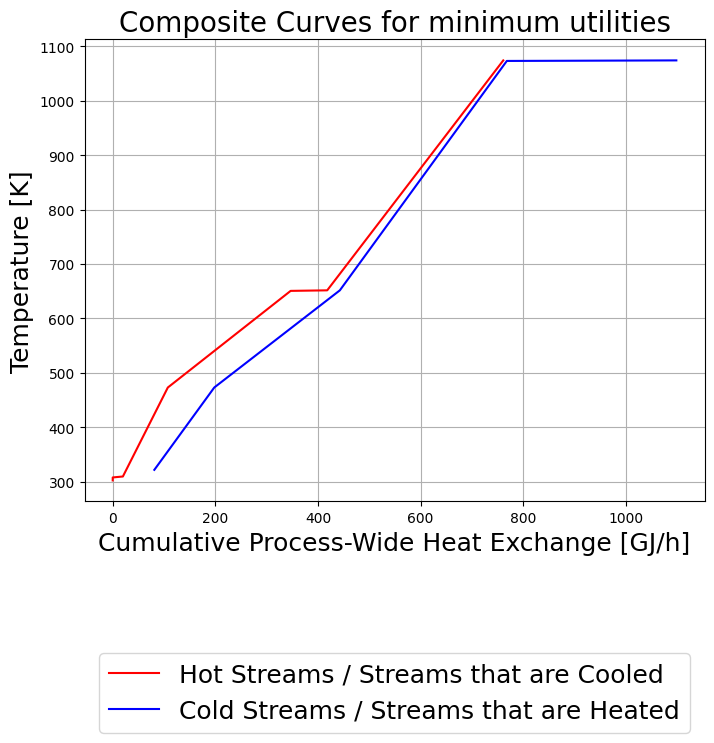

Heat utility =  337.2576718235101 GJ/h
cold utility =  81.10167238651394 GJ/h
Downstream emissions =  8.861397794431719 kg CO2e/GJ fuel
MSP =  10.411321005934349 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1521.1     2002.5
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17774    0.13502
    Total Mole Fraction methane   dimensionless   0.081100    0.27282    0.22673
    Total Mole Fraction ethane    dimensionless    0.46920    0.20919    0.27170
    Total Mole Fraction propane   dimensionless    0.30920   0.046594    0.10972
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032215
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074826   0.0632


Unit : fs.T102                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                           Units        Inlet      Outlet  
    Total Molar Flowrate                mole / second     1701.4          -
    Total Mole Fraction hydrogen        dimensionless    0.16051          -
    Total Mole Fraction methane         dimensionless    0.24638          -
    Total Mole Fraction ethane          dimensionless    0.18995          -
    Total Mole Fraction propane         dimensionless   0.043495          -
    Total Mole Fraction nbutane         dimensionless   0.018245          -
    Total Mole Fraction ibutane         dimensionless   0.074395          -
    Total Mole Fraction pentane         dimensionless   0.021131          -
    Total Mole Fraction hexane          dimensionless  0.0028072          -
    Total Mole Fraction heptane         dimensionles

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

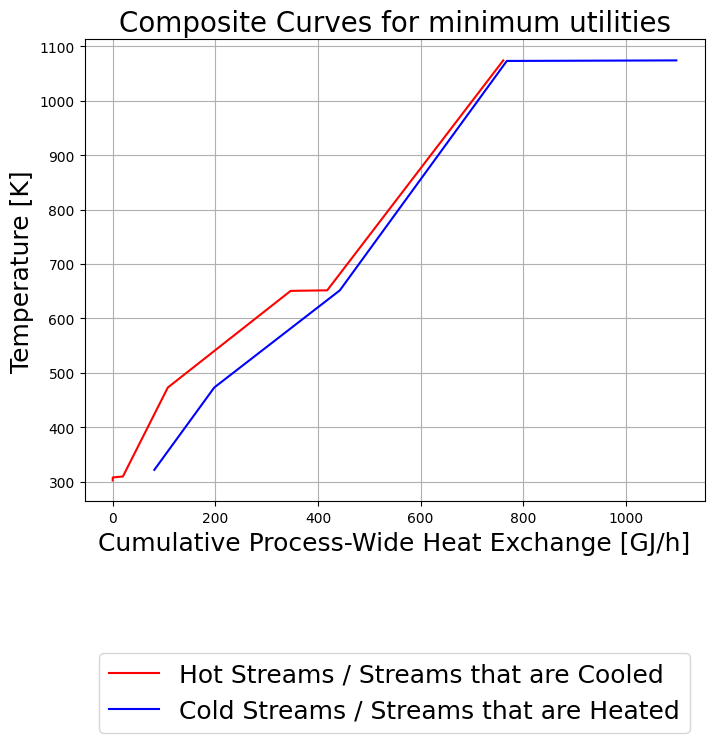

Heat utility =  337.25444995742095 GJ/h
cold utility =  81.10074353075993 GJ/h
Downstream emissions =  8.861276944805015 kg CO2e/GJ fuel
MSP =  10.7661828956052 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1521.0     2002.4
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17776    0.13502
    Total Mole Fraction methane   dimensionless   0.081100    0.27284    0.22675
    Total Mole Fraction ethane    dimensionless    0.46920    0.20921    0.27171
    Total Mole Fraction propane   dimensionless    0.30920   0.046597    0.10973
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032215
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074803   0.06319

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

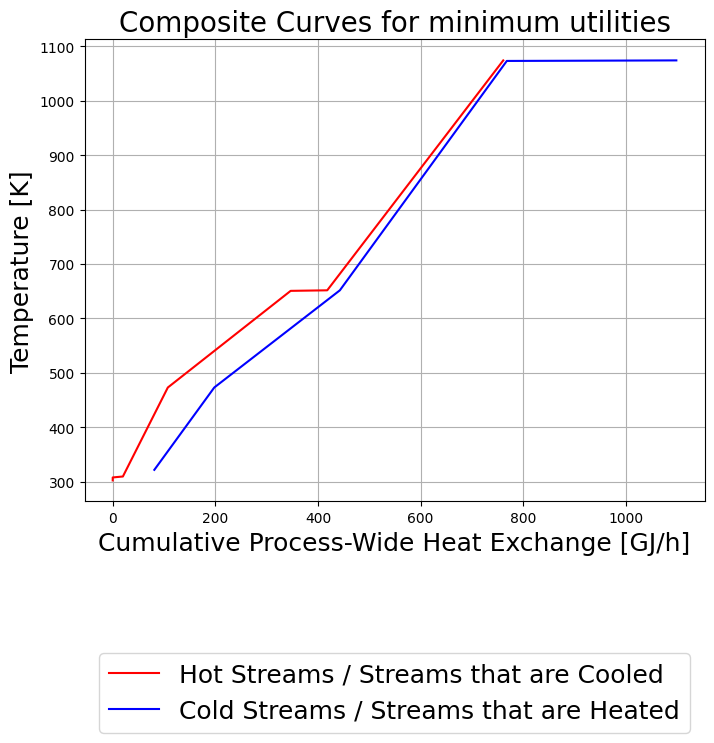

Heat utility =  337.25120868411267 GJ/h
cold utility =  81.09995419046234 GJ/h
Downstream emissions =  8.861149080398395 kg CO2e/GJ fuel
MSP =  11.387245488032661 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1520.9     2002.3
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17777    0.13503
    Total Mole Fraction methane   dimensionless   0.081100    0.27287    0.22676
    Total Mole Fraction ethane    dimensionless    0.46920    0.20923    0.27173
    Total Mole Fraction propane   dimensionless    0.30920   0.046600    0.10973
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032216
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074783   0.063


Unit : fs.C101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                   : Value      : Units         : Fixed : Bounds
    Isentropic Efficiency :    0.85000 : dimensionless :  True : (None, None)
          Mechanical Work :     55700. :          watt : False : (None, None)
          Pressure Change : 3.6805e+05 :        pascal : False : (None, None)
           Pressure Ratio :     3.8350 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                     Units         Inlet     Outlet  
    Total Molar Flowrate          mole / second     13.182     13.182
    Total Mole Fraction ethane    dimensionless    0.25660    0.25660
    Total Mole Fraction propane   dimensionless   0.099953   0.099953
    Total Mole Fraction

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

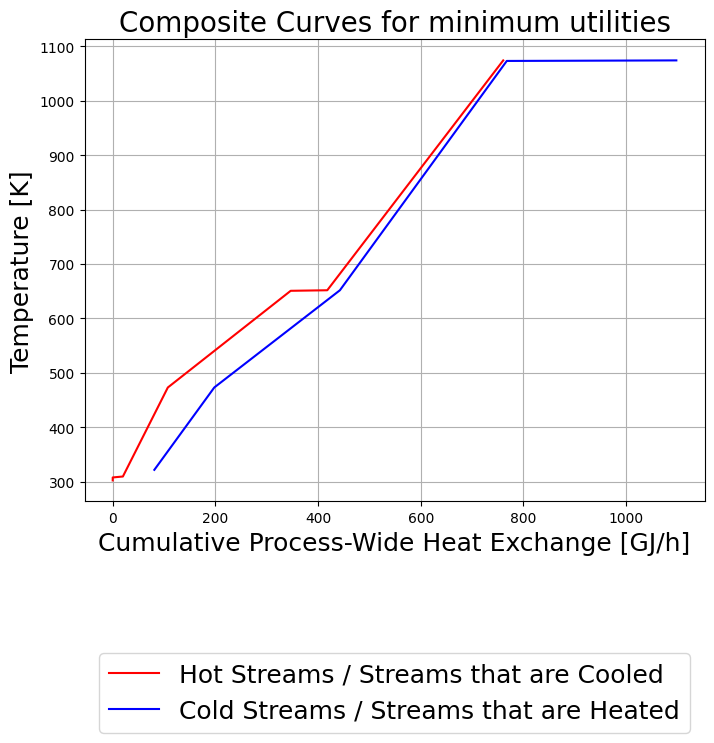

Heat utility =  337.23673238093295 GJ/h
cold utility =  81.09599973607482 GJ/h
Downstream emissions =  8.860584820330857 kg CO2e/GJ fuel
MSP =  14.603131988286021 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1520.3     2001.7
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17783    0.13507
    Total Mole Fraction methane   dimensionless   0.081100    0.27297    0.22683
    Total Mole Fraction ethane    dimensionless    0.46920    0.20930    0.27180
    Total Mole Fraction propane   dimensionless    0.30920   0.046614    0.10976
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017598   0.032220
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074692   0.063

The initial DOF is 8
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

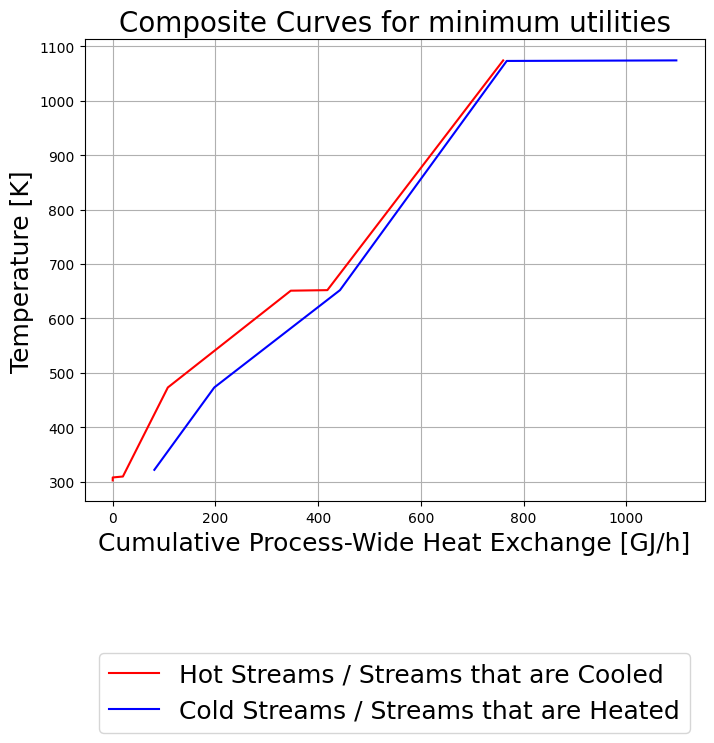

Heat utility =  337.2117682967911 GJ/h
cold utility =  81.08967034754069 GJ/h
Downstream emissions =  8.859601354413165 kg CO2e/GJ fuel
MSP =  19.481159805221985 $/GJ

Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1519.2     2000.6
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17795    0.13513
    Total Mole Fraction methane   dimensionless   0.081100    0.27316    0.22695
    Total Mole Fraction ethane    dimensionless    0.46920    0.20944    0.27194
    Total Mole Fraction propane   dimensionless    0.30920   0.046639    0.10982
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017599   0.032228
    Total Mole Fraction ibutane   dimensionless   0.026500   0.074541   0.0629


Unit : fs.C102                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                   : Value      : Units         : Fixed : Bounds
    Isentropic Efficiency :    0.85000 : dimensionless :  True : (None, None)
          Mechanical Work : 1.6002e+06 :          watt : False : (None, None)
          Pressure Change : 2.0210e+05 :        pascal : False : (None, None)
           Pressure Ratio :     1.4059 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                     Units         Inlet     Outlet  
    Total Molar Flowrate          mole / second     1519.2     1519.2
    Total Mole Fraction hydrogen  dimensionless    0.17795    0.17795
    Total Mole Fraction methane   dimensionless    0.27316    0.27316
    Total Mole Fraction

In [19]:
for c_tax_rate in c_tax_rates:
    m.fs.c_tax_rate = c_tax_rate
    
    # unfix DOFs
    unfix_DOFs_pre_optimization(m)
    
    DOF_initial = degrees_of_freedom(m)
    print("The initial DOF is {0}".format(DOF_initial))
    
    # Solve optimization problem
    solver = SolverFactory('ipopt')
    solver.options = {'tol': 1e-6,
                      'bound_push': 1e-8,
                      'max_iter': 100,
                     }
    solve_status = solver.solve(m, tee=True)

    # Fix DOFs
    fix_DOFs_post_optimization(m)
    
    # Save and display results
    ms.to_json(m, fname="./initialization_files/CISTAR_optimal_solution_{}_C_tax_{}_M{}_purge_{}_sequential_solve.json.gz".format(case_name,m.fs.c_tax_rate(), model_code,round(m.fs.S102.split_fraction[0, "purge"](),3)))
    
    CDs = heat_ex_data(m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102])
    generate_curves(CDs)
    
    print('Heat utility = ', m.fs.Qs(), 'GJ/h')
    print('cold utility = ', m.fs.Qw(), 'GJ/h')
    print('Downstream emissions = ', m.fs.downstream_emissions(), 'kg CO2e/GJ fuel')
    print('MSP = ', m.fs.min_sell_price(), '$/GJ')

    m.fs.M101.report()
    m.fs.H101.report()
    m.fs.R101.report()
    m.fs.H102.report()
    m.fs.S101.report()
    m.fs.E101.report()
    m.fs.H103.report()
    m.fs.R102.report()
    m.fs.H104.report()
    m.fs.T101.report()
    m.fs.H105.report()
    m.fs.F101.report()
    m.fs.H106.report()
    m.fs.F102.report()
    m.fs.T102.report()
    m.fs.T103.report()
    m.fs.C101.report()
    m.fs.M102.report()
    m.fs.S102.report()
    m.fs.C102.report()